In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import multiprocessing as multi
import numpy as np
import os 
import pandas as pd
import pmagpy
import pmagpy.pmag as pmag
import pmagpy.ipmag as ipmag
import pmagpy.pmagplotlib as pmagplotlib
import re
import scipy.integrate as integrate
import scipy.stats as stats
import seaborn as sns
#print(sns.__version__)
import SPD.lib.leastsq_jacobian as lib_k
import sys

from datetime import datetime as dt
from importlib import reload
from multiprocessing import Pool

import pmagpy.tsunashawfuncs as ts
#import tsunashawfuncs as ts
import importlib

## How to use

1) Make a directory and put this notebook to the directory, then also make following sub-directories: 'data/', 'MagIC/', 'plots/', 'csv/', 'Figures'

2) Put a raw measurement data file in the sub-directory of 'data/'. An example data file "mc120c-SA4.d" is provided with this notebook.

3) Choose and set proper setting/variables at the beginning of this notebook.

4) Once run the notebook thoroughly. A file "steps_template.csv" is created in the sub-directory of 'csv/'. If you prefer to select a specific coercivity interval for a specific specimen, you can edit the file and rename it to "steps.csv" and save it. When you run the notebook again, an analyis will be made according to the "steps.csv".

5) All analytical results will be created in the sub-directories.

## Check PmagPy version
anaconda3/lib/python3.6/site-packages/pmagpy (to update : pip install -U pmagpy);
or
cd /home/pmag/PmagPy; git pull

In [2]:
pmag.get_version()

'pmagpy-4.2.96'

## Choose the analysis method for Tsunakawa-Shaw API estimation
#### ordinary: find the reasonable portion, by criteria of Yamamoto et al. (2003) using r, since 2003
#### best_reg: find the best portion, by criteria of Yamamoto et al. (2003) using r, since 2022
(1) calculate API statistics for all possible coercivity intervals
(2) discard the statistics not satisfying the usual selection criteria (when applicable)
(3 omitted) sort the statistics by dAPI (rel. departure from the expected API), and select the best 10 statistics
(4) sort the statistics by frac_n, and select the best one
Curvature (k) calculation is made by the code for Arai plot by Lisa. This is done for inverterd-X (e.g. -TRM1, -ARM1, ..) and original-Y (e.g. NRM, ARM0, ..). The inverted-X is offset (positive) to zero as a minimum.
#### best_krv - find the best portion, output "best" files, by criteria of Lloyd et al. (2021) using k'
(1) calculate API statistics for all possible coercivity intervals
(2) discard the statistics not satisfying the Beta criterion (0.1) and the k' criterion (0.2)
(3 omitted) sort the statistics by dAPI (rel. departure from the expected API), and select the best 10 statistics
(4) sort the statistics by frac_n, and select the best one

In [3]:
#analysis='ordinary'
analysis='best_reg'
#analysis='best_krv'

#### threshold values for criteria: Yamamoto et al. (2003) and Lloyd et al.(2021)

In [4]:
minN=4 # minimum number of data points
minR=0.995 # minimum correlation coefficient of a slope
#minR=0.90 # minimum correlation coefficient of a slope
minSlopeT=0.95 # minimum slope of TRM1-TRM2* plot
#minSlopeT=0.9 # minimum slope of TRM1-TRM2* plot
maxSlopeT=1.05 # minimum slope of TRM1-TRM2* plot
#maxSlopeT=1.1 # minimum slope of TRM1-TRM2* plot
minFrac=0.15 # minimum frac of NRM-TRM1* and TRM1-TRM2* plots
#minFrac=0.30 # minimum frac of NRM-TRM1* and TRM1-TRM2* plots

In [5]:
maxKrv=0.20 # consideration for Lloyd et al.(2021)
maxBeta=0.10 # consideration for Lloyd et al.(2021)
maxFresid=0.10 # consideration for Lloyd et al.(2021)

## Set variables

### file paths (directories)

In [6]:
source_directory='data_files/tsunakawa_shaw/raw_data/'
MagIC_directory='data_files/tsunakawa_shaw/MagIC/'
Plot_directory='data_files/tsunakawa_shaw/plots/'
csv_directory='data_files/tsunakawa_shaw/csv/'
dir_path='data_files/tsunakawa_shaw/Figures'

### sample description for MagIC

In [7]:
lat,lon=0, 0
height=''
location='na'
location_type='outcrop'

In [8]:
age="0"
age_min,age_max="0","0"
age_unit='Ma'

In [9]:
classes='intrusive:igneous'
geologic_types='Intrusives'
lithologies='basalt'

In [10]:
sample_methods='FS-FD:SO-SM'

In [11]:
citations='na'

### experimental condition

In [12]:
method_codes_first='LT-NRM-PAR:LP-PI-TRM:IE-SH:LP-LT:DA-ALT-RS:DA-AC-AARM'
method_codes_second='LT-TRM-PAR:LP-PI-TRM:IE-SH:LP-LT:DA-ALT-RS:DA-AC-AARM'
instrument="KCC-DSPIN"

In [13]:
ARM_DC_field=50e-6 # DC field values for ARMs, 50uT
True_API=70e-6 # expected API values for NRMs (LabTRMs)

## Read raw data; convert to MAGIC format

In [14]:
files=os.listdir(MagIC_directory)
for file in files:
    if '.magic' in file:
        os.remove(MagIC_directory+file)
    elif '.specimens' in file:
        os.remove(MagIC_directory+file)
    elif '.samples' in file:
        os.remove(MagIC_directory+file)


In [15]:
files=os.listdir(source_directory)
files

['mc120c-SA4.d']

In [16]:
files=os.listdir(source_directory)
for infile in files:
    file=source_directory+infile
    meas_data,spec_data,samp_data=\
        ts.convert_ts_dspin(file, citations, instrument, ARM_DC_field)
    # save measurements file
    meas_file=MagIC_directory+infile+'.magic'
    meas_out=meas_data.to_dict('records')
    pmag.magic_write(meas_file,meas_out,'measurements')
    # save specimens file
    spec_file=MagIC_directory+infile+'.specimens'
    spec_out=spec_data.to_dict('records')
    pmag.magic_write(spec_file,spec_out,'specimens')
    samp_data['lat']=lat
    samp_data['lon']=lon
    samp_data['method_codes']=sample_methods
    samp_data['result_type']='i'
    samp_data['result_quality']='g'
    samp_data['citations']=citations
    # save sample file
    samp_file=MagIC_directory+infile+'.samples'
    samp_out=samp_data.to_dict('records')
    pmag.magic_write(samp_file,samp_out,'samples')

150  records written to file  data_files/tsunakawa_shaw/MagIC/mc120c-SA4.d.magic
1  records written to file  data_files/tsunakawa_shaw/MagIC/mc120c-SA4.d.specimens
1  records written to file  data_files/tsunakawa_shaw/MagIC/mc120c-SA4.d.samples


In [17]:
magic_files=os.listdir(MagIC_directory)
magic_list,specimens_list,sample_list=[],[],[]
for f in magic_files: 
    if '.magic' in f:
        magic_list.append(MagIC_directory+f)
    elif '.specimens' in f:
        specimens_list.append(MagIC_directory+f)
    elif '.samples' in f:
        sample_list.append(MagIC_directory+f)

magic_list.sort()
specimens_list.sort()
sample_list.sort()

ipmag.combine_magic(magic_list,MagIC_directory+'measurements.txt',\
                    data_model=3,magic_table='measurements')
ipmag.combine_magic(specimens_list,MagIC_directory+'specimens.txt',\
                    data_model=3,magic_table='specimens')
ipmag.combine_magic(sample_list,MagIC_directory+'samples.txt',\
                    data_model=3,magic_table='samples')
# make a backup! 
#copyfile(MagIC_directory+'specimens.txt',MagIC_directory+'specimens_orig.txt')
#copyfile(MagIC_directory+'samples.txt',MagIC_directory+'samples_orig.txt')

-I- Using online data model
-I- Getting method codes from earthref.org
-I- Importing controlled vocabularies from https://earthref.org
adding measurement column to measurements table!
-I- overwriting /Users/ltauxe/PmagPy/measurements.txt
-I- 150 records written to measurements file
-I- overwriting /Users/ltauxe/PmagPy/data_files/tsunakawa_shaw/MagIC/measurements.txt
-I- 150 records written to measurements file
-I- overwriting /Users/ltauxe/PmagPy/data_files/tsunakawa_shaw/MagIC/specimens.txt
-I- 1 records written to specimens file
-I- overwriting /Users/ltauxe/PmagPy/data_files/tsunakawa_shaw/MagIC/samples.txt
-I- 1 records written to samples file


'/Users/ltauxe/PmagPy/data_files/tsunakawa_shaw/MagIC/samples.txt'

## Create the template files

### 1) siteinfo_template.csv: template file for sample data <age, lat, long>

In [18]:
sample_df=pd.read_csv(MagIC_directory+'samples.txt',sep='\t',header=1)
sample_df=sample_df.rename(columns={'sample': 'sample_name'})
sample_df=sample_df.sort_values('sample_name')

sids=sample_df.site.unique()
siteinfo_df=pd.DataFrame(sids)
siteinfo_df.columns=['site']

siteinfo_df['age']=age
siteinfo_df['age_high']=age_max
siteinfo_df['age_low']=age_min
siteinfo_df['age_unit']=age_unit

siteinfo_df['lat']=lat
siteinfo_df['lon']=lon
siteinfo_df['height']=height

siteinfo_df['geologic_classes']=classes
siteinfo_df['geologic_types']=geologic_types
siteinfo_df['lithologies']=lithologies
siteinfo_df['location']=location
siteinfo_df['location_type']=location_type

siteinfo_df['citations']=citations

siteinfo_df.to_csv(csv_directory+'siteinfo_template.csv',index=None)

### 2) steps_template.csv: template file for step wishes to use for main analyses

In [19]:
spec_df=pd.read_csv(MagIC_directory+'specimens.txt',sep='\t',header=1)
spec_df=spec_df.sort_values('specimen')
sids=spec_df.specimen.unique()
step_df=pd.DataFrame(sids)
step_df.columns=['specimen']

step_df['zijd_min']=0
step_df['zijd_max']=180.
step_df['trm1_star_min']=0
step_df['trm1_star_max']=180.
step_df['trm2_star_min']=0
step_df['trm2_star_max']=180.

step_df.to_csv(csv_directory+'steps_template.csv',index=None)

## Main Analysis
If "steps.csv" exists, step wishes are read from the file.
Otherwise, optimization process is done to find a reasonble step interval to estimate an API, then it is saved to "steps_optimum.csv".
Final specimen-level results are saved to "specimen_results.csv"

### remove existing plots

In [20]:
plot_files=os.listdir(Plot_directory)
for file in plot_files:
    if '.pdf' in file:
        os.remove(Plot_directory+file)

### read in measurements data

In [21]:
meas=pd.read_csv(MagIC_directory+'measurements.txt',sep='\t',header=1)
#print(meas)
#meas=meas.sort_values('specimen')
meas['dir_dec_diff']=""
meas['dir_inc_diff']=""
meas['magn_mass_diff']=""
meas['treat_ac_field_mT']=meas['treat_ac_field']*1e3 # for convenience

### set specimen ids

In [22]:
sids=meas.specimen.unique()
print(sids)

['mc120c-SA4']


### read in the specimen treatment step wishes from "steps.csv"
If the file "steps.csv" does not exist in the csv directory, set the maximum intervals. If exists, Zijderveld intervals are applied for all the three analyses, while the NRM-TRM1* and TRM1-TRM2* intervals are not applied for the best_reg and best_krv analyses

In [23]:
step_wishes=True
try:
    steps_df=pd.read_csv(csv_directory+'steps.csv')
except IOError:
    step_wishes=False
    steps_df=pd.DataFrame(sids)
    steps_df.columns=['specimen']
    steps_df=steps_df.set_index('specimen')
    #meas=meas.set_index(['specimen','description'])
    for sid in sids:
        meas_n=meas[ (meas.description.str.contains('NRM')==True)
                 & (meas.specimen.str.contains(sid)==True)]
        meas_t1=meas[ (meas.description.str.contains('TRM1')==True)
                 & (meas.specimen.str.contains(sid)==True)]
        meas_t2=meas[ (meas.description.str.contains('TRM2')==True)
                 & (meas.specimen.str.contains(sid)==True)]
        if(len(meas_n)>0):
            meas_n=meas_n.set_index(['specimen','description'])
            steps_df.loc[sid,'zijd_min']=meas_n.loc[sid,'NRM'].treat_ac_field_mT.min()
            steps_df.loc[sid,'zijd_max']=meas_n.loc[sid,'NRM'].treat_ac_field_mT.max()
        if(len(meas_t1)>0):
            meas_t1=meas_t1.set_index(['specimen','description'])
            steps_df.loc[sid,'trm1_star_min']=meas_t1.loc[sid,'TRM1'].treat_ac_field_mT.min()
            steps_df.loc[sid,'trm1_star_max']=meas_t1.loc[sid,'TRM1'].treat_ac_field_mT.max()
        if(len(meas_t2)>0):
            meas_t2=meas_t2.set_index(['specimen','description'])
            steps_df.loc[sid,'trm2_star_min']=meas_t2.loc[sid,'TRM2'].treat_ac_field_mT.min()
            steps_df.loc[sid,'trm2_star_max']=meas_t2.loc[sid,'TRM2'].treat_ac_field_mT.max()
    steps_df=steps_df.reset_index()
    meas=meas.reset_index()
if (step_wishes == True): print("step wishes: successfully read from 'steps.csv'")
if (step_wishes == False): print("step wishes: 'steps.csv' does not exist, set maximum intervals")
#print(steps_df)

step wishes: 'steps.csv' does not exist, set maximum intervals


### main loop

In [24]:
importlib.reload(ts)

<module 'pmagpy.tsunashawfuncs' from '/Users/ltauxe/PmagPy/pmagpy/tsunashawfuncs.py'>

In [25]:
## remanence type
ntrm_types=['NRM','TRM1','TRM2']
arm_types=['ARM0','ARM1','ARM2']

## prepare dataframe for this specimen for private data output
spec_prv_df=pd.DataFrame(sids)
spec_prv_df.columns=['specimen']
spec_prv_df=spec_prv_df.set_index('specimen')

## prepare for main loop
cnt=1 # plot counter
sidPars=[] # list of dictionaries for specimen intensity statistics
stepRecs=[] # list of step wishes after optimization 

--------------
[working on:  mc120c-SA4 ]
NRM:  24  data, TRM1: 24  data, TRM2: 24  data
ARM0:  24  data, ARM1: 24  data, ARM2: 24  data


ValueError: cannot insert level_0, already exists

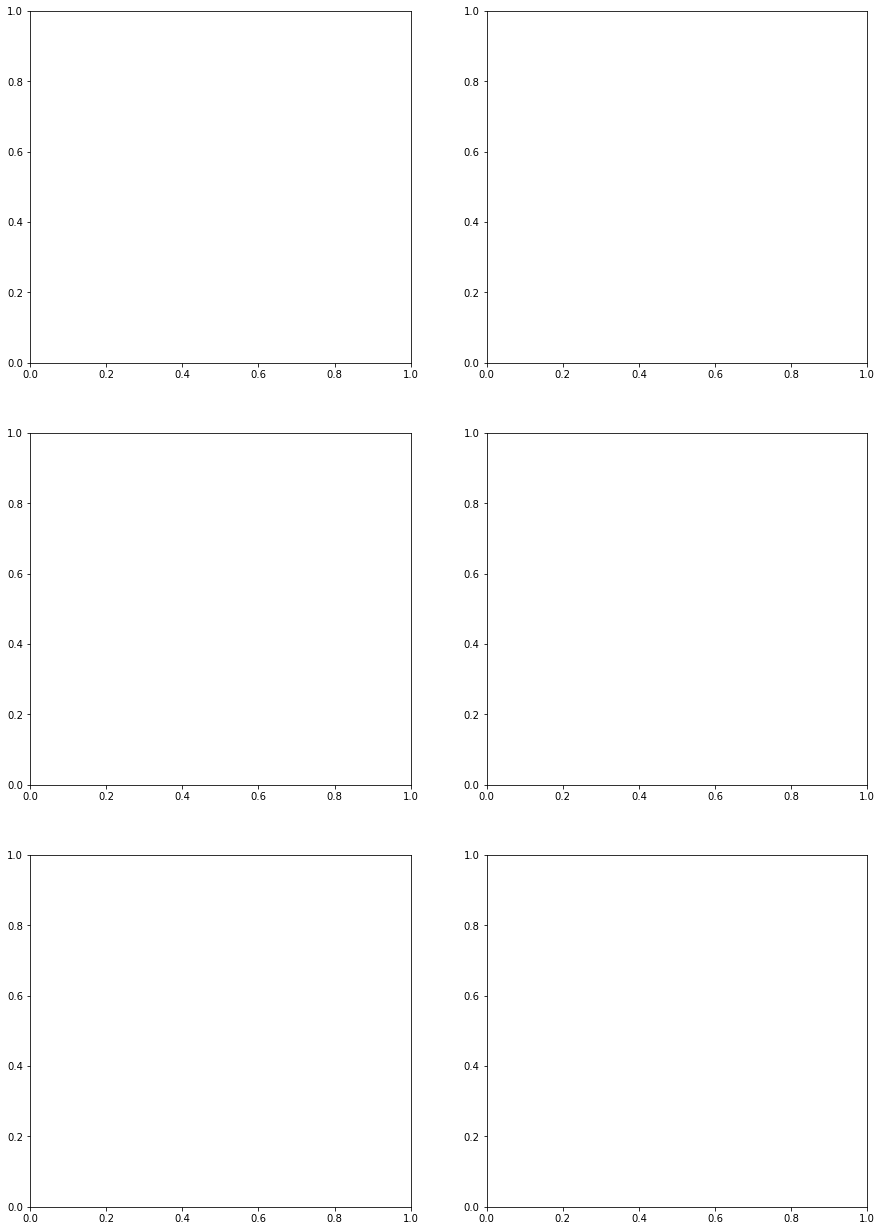

In [47]:
reload (ts)
## step through the specimens
## for sid in ['SW01-01A-1_sun','SW01-02A-1_sun', 'SW01-03A-1_sun']:
for sid in sids:
    print ('--------------')
    print ('[working on: ', sid, ']')

    ## make a dictionary for this specimen's statistics
    sidpars_nrm={}
    sidpars_nrm['specimen']=sid
    sidpars_nrm['int_corr']='c'
    sidpars_nrm['citations']=citations
    sidpars_nrm['method_codes']=method_codes_first
    #
    sidpars_trm={}
    sidpars_trm['specimen']=sid
    sidpars_trm['int_corr']='c'
    sidpars_trm['citations']=citations
    sidpars_trm['method_codes']=method_codes_second
    #
    steprec={}
    steprec['specimen']=sid
    
    ## select the measurement data for this specimen
    sid_data=meas[meas.specimen==sid]

    ## substitute lab_field
    aftrm10=sid_data[sid_data.description.str.contains('TRM10')]
    if (len(aftrm10)>0): lab_field=aftrm10.treat_dc_field.tolist()[0]

    ## preparation of data
    sid_data,sid_df,afnrm,aftrm1,aftrm2,afarm0,afarm1,afarm2 \
        =ts.prep_sid_df(ntrm_types+arm_types,sid_data)

    ## data output: AF vs XRM intensity
    sid_df.to_csv(csv_directory+sid+'_af_vs_xrms.csv',index=True)

    ## get the treatment steps for this specimen
    #print(steps_df)
    sid_steps=steps_df[steps_df.specimen==sid].head(1)
    #print(sid_steps)
    if (len(afnrm)>0):
        zijd_min,zijd_max=sid_steps.zijd_min.values[0],sid_steps.zijd_max.values[0]
    if (len(aftrm1)>0) & (len(afarm1)>0):
        trm1_star_min,trm1_star_max=sid_steps.trm1_star_min.values[0],sid_steps.trm1_star_max.values[0]
    if (len(aftrm2)>0) & (len(afarm2)>0):
        trm2_star_min,trm2_star_max=sid_steps.trm2_star_min.values[0],sid_steps.trm2_star_max.values[0]
    
    ## Fig1: AF vs XRM intensity
    ##       with output of relevant data 
    fig1=plt.figure(cnt,figsize=(15,22))
    fig1.clf()
    ax1,ax2,ax3,ax4,ax5,ax6 =\
        fig1.add_subplot(321),fig1.add_subplot(322),fig1.add_subplot(323),\
        fig1.add_subplot(324),fig1.add_subplot(325),fig1.add_subplot(326)
    for t in (ntrm_types+arm_types):
        [x1,x2,x3,x4,x5]=[0,0,0,0,0]
        if (t=='NRM')  & (len(afnrm)>0):
            x1,x2,x3,x4,x5=ts.plot_af_xrm(sid,sid_data,ax1,afnrm,t)
        if (t=='TRM1') & (len(aftrm1)>0):
            x1,x2,x3,x4,x5=ts.plot_af_xrm(sid,sid_data,ax3,aftrm1,t)
        if (t=='TRM2') & (len(aftrm2)>0):
            x1,x2,x3,x4,x5=ts.plot_af_xrm(sid,sid_data,ax5,aftrm2,t)
        if (t=='ARM0') & (len(afarm0)>0):
            x1,x2,x3,x4,x5=ts.plot_af_xrm(sid,sid_data,ax2,afarm0,t)
            rem_ltd_perc=100.* (x4 - 1.0)/x4
            spec_prv_df.loc[sid,'ltd%_ARM0']='%7.1f'%(rem_ltd_perc)
            sidpars_nrm['rem_ltd_perc']='%7.1f'%(rem_ltd_perc)
        if (t=='ARM1') & (len(afarm1)>0):
            x1,x2,x3,x4,x5=ts.plot_af_xrm(sid,sid_data,ax4,afarm1,t)
            rem_ltd_perc_1=100.* (x4 - 1.0)/x4
            spec_prv_df.loc[sid,'ltd%_ARM1']='%7.1f'%(rem_ltd_perc_1)
        if (t=='ARM2') & (len(afarm2)>0):
            x1,x2,x3,x4,x5=ts.plot_af_xrm(sid,sid_data,ax6,afarm2,t)
            rem_ltd_perc_2=100.* (x4 - 1.0)/x4
            spec_prv_df.loc[sid,'ltd%_ARM2']='%7.1f'%(rem_ltd_perc_2)
        if (abs(x1+x2+x3+x4+x5)>0):
            afdmax=x1
            s1='MDF_'+str(t)
            s2=str(t)+'_0mT(uAm2/kg)'
            s3=str(t)+'0/'+str(t)+'_0mT'
            s4=str(t)+'_'+str(int(afdmax))+'mT/'+str(t)+'_0mT'
            #print(s1, s2, s3, s4)
            spec_prv_df.loc[sid,s1],spec_prv_df.loc[sid,s2],\
            spec_prv_df.loc[sid,s3],spec_prv_df.loc[sid,s4]\
                =float('{:.4e}'.format(x2)),float('{:.4e}'.format(x3)),\
                    float('{:.4e}'.format(x4)),float('{:.4e}'.format(x5))
            #print(spec_prv_df)
    fig1.savefig(Plot_directory+sid+'_afdemag.pdf')
    cnt=cnt+1
    
    ## opt interval search (min MAD, DANG) for Zijderveld
    if (step_wishes == False) & (len(afnrm)>0):
        zijd_max=afnrm['treat_ac_field_mT'].tolist()[len(afnrm)-1]
        zijd_min, zijd_max = ts.opt_interval_zij(afnrm, minN)
        steprec['zijd_min'],steprec['zijd_max'] = zijd_min, zijd_max

    ## Fig2: Zijderveld plot for the NRM demag directions
    ##       with output of relevant data 
    fig2=plt.figure(cnt,figsize=(10,5))
    fig2.clf()
    ax1, ax2 =fig2.add_subplot(121), fig2.add_subplot(122)
    if (len(afnrm)>0):
        x1,x2,x3,x4=ts.plot_zijd(sid, sid_data, ax1, ax2, afnrm, zijd_min, zijd_max)
        sidpars_nrm['dir_dec']='%7.1f'%(x1)
        sidpars_nrm['dir_inc']='%7.1f'%(x2)
        sidpars_nrm['dir_mad_free']='%7.1f'%(x3)
        spec_prv_df.loc[sid,'from_zijd']='%7.1f'%(zijd_min)
        spec_prv_df.loc[sid,'to_zijd']='%7.1f'%(zijd_max)
        spec_prv_df.loc[sid,'PCA_Dec']='%7.1f'%(x1)
        spec_prv_df.loc[sid,'PCA_Inc']='%7.1f'%(x2)
        spec_prv_df.loc[sid,'PCA_MAD']='%7.1f'%(x3)
        spec_prv_df.loc[sid,'PCA_N']='%2d'%(x4)
    fig2.savefig(Plot_directory+sid+'_zijd.pdf')  
    cnt=cnt+1

    ## Fig3: basic plots (NRM-ARM0, TRM1-ARM1, TRM2-ARM2)
    ##       with output of relevant data 
    fig3=plt.figure(cnt,figsize=(10,10))
    fig3.clf()
    ax1,ax2,ax3 = fig3.add_subplot(221),fig3.add_subplot(222),fig3.add_subplot(223)
    for (t1,t2) in zip(ntrm_types,arm_types):
        [x1,x2,x3,x4,x5]=[0,0,0,0,0]
        if (t1=='NRM') & (t2=='ARM0') & (len(afnrm)>0) & (len(afarm0)>0):
            x1,x2,x3,x4,x5=\
                ts.plot_ntrm_arm(sid,ax1,sid_df,afnrm,zijd_min,zijd_max,'arm0','nrm')
        if (t1=='TRM1') & (t2=='ARM1') & (len(aftrm1)>0) & (len(afarm1)>0):
            x1,x2,x3,x4,x5=\
                ts.plot_ntrm_arm(sid,ax2,sid_df,aftrm1,zijd_min,zijd_max,'arm1','trm1')
        if (t1=='TRM2') & (t2=='ARM2') & (len(aftrm2)>0) & (len(afarm2)>0):
            x1,x2,x3,x4,x5=\
                ts.plot_ntrm_arm(sid,ax3,sid_df,aftrm2,zijd_min,zijd_max,'arm2','trm2')
        if (abs(x1+x2+x3+x4+x5)>0):
            ss=str(t1)+'-'+str(t2)
            [s1,s2,s3,s4,s5]=['slope_'+ss, 'r_'+ss, 'N_'+ss, 'k_'+ss, 'k\'_'+ss, ]
            spec_prv_df.loc[sid,s1]='%7.3f'%(x1)
            spec_prv_df.loc[sid,s2]='%7.3f'%(x2)
            spec_prv_df.loc[sid,s3]='%2d'%(x3)
            spec_prv_df.loc[sid,s4]='%7.3f'%(x4)
            spec_prv_df.loc[sid,s5]='%7.3f'%(x5)
    fig3.savefig(Plot_directory+sid+'_ratios1.pdf')
    cnt=cnt+1
    
    ## set the interval for NRM-TRM1* and TRM1-TRM2*
    if (len(afnrm)>0) & (len(aftrm1)>0) & (len(afarm0)>0) & (len(afarm1)>0):
        if (step_wishes == False) & (analysis == 'ordinary'):
            trm1_star_min, trm1_star_max =\
                ts.opt_interval_first_heating(zijd_min,sid_df,afnrm,minN,minFrac,minR)
        if (analysis == 'best_reg') or (analysis == 'best_krv'):
            combinedRegs1=ts.API_param_combine(sid_df,afnrm,aftrm1,zijd_min,minN) 
            if (analysis == 'best_reg'):
                trm1_star_min,trm1_star_max,trm2_star_min,trm2_star_max,allrst =\
                    ts.find_best_API_portion_r(combinedRegs1,minFrac,minR,\
                                               minSlopeT,maxSlopeT)
            if (analysis == 'best_krv'):
                trm1_star_min,trm1_star_max,trm2_star_min,trm2_star_max,allrst =\
                    ts.find_best_API_portion_k(combinedRegs1,maxBeta,maxFresid,maxKrv)
        steprec['trm1_star_min'],steprec['trm1_star_max'] = trm1_star_min, trm1_star_max
    if (len(aftrm1)>0) & (len(aftrm2)>0) & (len(afarm1)>0) & (len(afarm2)>0):
        if (step_wishes == False) & (analysis == 'ordinary'):
            trm2_star_min, trm2_star_max =\
                ts.opt_interval_second_heating(sid_df,aftrm1,\
                                               minN,minFrac,minR,minSlopeT,maxSlopeT)
        steprec['trm2_star_min'],steprec['trm2_star_max'] = trm2_star_min, trm2_star_max
    
    ## Fig4: main plots (NRM-TRM1*, TRM1-TRM2*)
    fig4=plt.figure(cnt,figsize=(10,5))
    fig4.clf()
    ax1, ax2 =fig4.add_subplot(121), fig4.add_subplot(122)
    # TRM1 on TRM2*
    [x1,x2,x3,x4,x5,x6,x7,x8]=[0,0,0,0,0,0,0,0]
    if (len(aftrm1)>0) & (len(aftrm2)>0) & (len(afarm1)>0) & (len(afarm2)>0):
        if (analysis == 'ordinary') or (analysis == 'best_reg'):
            x1,x2,x3,x4,x5,x6,x7,x8,ss1 =\
                ts.plot_pint_main(sid,ax2,sid_df,aftrm1,'trm2_star','trm1',\
                                  trm2_star_min,trm2_star_max,aftrm1,aftrm2,spec_prv_df,\
                                  'reg',minR,minFrac,minSlopeT,maxSlopeT,maxBeta,maxFresid,\
                                  maxKrv,lab_field)
        if (analysis == 'best_krv'):
            x1,x2,x3,x4,x5,x6,x7,x8,ss1 =\
                ts.plot_pint_main(sid,ax2,sid_df,aftrm1,'trm2_star','trm1',\
                                  trm2_star_min,trm2_star_max,\
                                  aftrm1,aftrm2,spec_prv_df,'krv',\
                                  minR,minFrac,minSlopeT,maxSlopeT,\
                                  maxBeta,maxFresid,maxKrv,lab_field)
    if (abs(x1+x2+x3+x4+x5+x6+x7+x8)>0):
        ss='TRM1-TRM2*'
        [s1,s2]=['from_'+ss, 'to_'+ss]
        spec_prv_df.loc[sid,s1]='%7.1f'%(trm2_star_min)
        spec_prv_df.loc[sid,s2]='%7.1f'%(trm2_star_max)
        [s1,s2,s3,s4,s5,s6,s7,s8] =\
            ['slope_'+ss, 'r_'+ss, 'N_'+ss, 'frac_'+ss, 'dAIC_'+ss, 'k_'+ss, 'k\'_'+ss, 'f_resid_'+ss]
        spec_prv_df.loc[sid,s1]='%7.3f'%(x1)
        spec_prv_df.loc[sid,s2]='%7.3f'%(x2)
        spec_prv_df.loc[sid,s3]='%2d'%(x3)
        spec_prv_df.loc[sid,s4]='%7.3f'%(x4)
        spec_prv_df.loc[sid,s5]='%7.3f'%(x5)
        spec_prv_df.loc[sid,s6]='%7.3f'%(x6)
        spec_prv_df.loc[sid,s7]='%7.3f'%(x7)
        spec_prv_df.loc[sid,s7]='%7.3f'%(x8)
        #
        sidpars_trm['description']='Values for the TRM1 normalized by TRM2*'
        sidpars_trm['meas_step_min']=trm2_star_min*1e-3
        sidpars_trm['meas_step_max']=trm2_star_max*1e-3
        #
        sidpars_trm['int_b']='%7.3f'%(x1)
        sidpars_trm['int_abs']=lab_field*x1
        sidpars_trm['int_r2_corr']='%7.3f'%(x2**2)
        sidpars_trm['int_n_measurements']=x3
        sidpars_trm['int_frac']='%7.3f'%(x4)
    # NRM on TRM1*
    [x1,x2,x3,x4,x5,x6,x7,x8]=[0,0,0,0,0,0,0,0]
    if (len(afnrm)>0) & (len(aftrm1)>0) & (len(afarm0)>0) & (len(afarm1)>0):
        if (analysis == 'ordinary') or (analysis == 'best_reg'):
            x1,x2,x3,x4,x5,x6,x7,x8,ss1 =\
                ts.plot_pint_main(sid,ax1,sid_df,afnrm,'trm1_star','nrm',\
                                  trm1_star_min,trm1_star_max,aftrm1,aftrm2,spec_prv_df,\
                                  'reg',minR,minFrac,minSlopeT,maxSlopeT,maxBeta,maxFresid,\
                                  maxKrv,lab_field)
        if (analysis == 'best_krv'):
            x1,x2,x3,x4,x5,x6,x7,x8,ss1 =\
                ts.plot_pint_main(sid,ax1,sid_df,afnrm,'trm1_star','nrm',\
                                  trm1_star_min,trm1_star_max,\
                                  aftrm1,aftrm2,spec_prv_df,'krv',\
                                  minR,minFrac,minSlopeT,maxSlopeT,\
                                  maxBeta,maxFresid,maxKrv,lab_field)
    if (abs(x1+x2+x3+x4+x5+x6+x7+x8)>0):
        ss='NRM-TRM1*'
        [s1,s2]=['from_'+ss, 'to_'+ss]
        spec_prv_df.loc[sid,s1]='%7.1f'%(trm1_star_min)
        spec_prv_df.loc[sid,s2]='%7.1f'%(trm1_star_max)
        [s1,s2,s3,s4,s5,s6,s7,s8] =\
            ['slope_'+ss, 'r_'+ss, 'N_'+ss, 'frac_'+ss, 'dAIC_'+ss, 'k_'+ss, 'k\'_'+ss, 'f_resid_'+ss]
        spec_prv_df.loc[sid,s1]='%7.3f'%(x1)
        spec_prv_df.loc[sid,s2]='%7.3f'%(x2)
        spec_prv_df.loc[sid,s3]='%2d'%(x3)
        spec_prv_df.loc[sid,s4]='%7.3f'%(x4)
        spec_prv_df.loc[sid,s5]='%7.3f'%(x5)
        spec_prv_df.loc[sid,s6]='%7.3f'%(x6)
        spec_prv_df.loc[sid,s7]='%7.3f'%(x7)
        spec_prv_df.loc[sid,s8]='%7.3f'%(x8)
        if (('rejected' in ss1) == False):
            spec_prv_df.loc[sid,'pint(uT)']='%7.3f'%(lab_field*x1*1e6)
            spec_prv_df.loc[sid,'min_pint(uT)_passed']='%7.3f'%(lab_field*min(allrst.slope_n)*1e6)
            spec_prv_df.loc[sid,'max_pint(uT)_passed']='%7.3f'%(lab_field*max(allrst.slope_n)*1e6)
        #
        sidpars_nrm['description']='Values for the NRM normalized by TRM1*'
        sidpars_nrm['meas_step_min']=trm1_star_min*1e-3
        sidpars_nrm['meas_step_max']=trm1_star_max*1e-3
        #
        sidpars_nrm['int_b']='%7.3f'%(x1)
        sidpars_nrm['int_abs']=lab_field*x1
        sidpars_nrm['int_r2_corr']='%7.3f'%(x2**2)
        sidpars_nrm['int_n_measurements']=x3
        sidpars_nrm['int_frac']='%7.3f'%(x4)
    if(analysis == 'ordinary'):
        fig4.savefig(Plot_directory+sid+'_corrected_ordinary.pdf')
    if(analysis == 'best_reg'):
        fig4.savefig(Plot_directory+sid+'_corrected_best_r.pdf')
    if(analysis == 'best_krv'):
        fig4.savefig(Plot_directory+sid+'_corrected_best_k.pdf')
    cnt=cnt+1

    ## Fig5: other basic plots (NRM-TRM1, ARM0-ARM1, TRM1-TRM2, ARM1-ARM2)
    fig5=plt.figure(cnt,figsize=(10,10))
    fig5.clf()
    ax1,ax2,ax3,ax4=\
        fig5.add_subplot(221),fig5.add_subplot(222),fig5.add_subplot(223),fig5.add_subplot(224)
    for t in (ntrm_types+arm_types):
        [x1,x2,x3,x4,x5]=[0,0,0,0,0]
        if (t=='NRM') & (len(aftrm1)>0) & (len(afnrm)>0):
            max_xrm=max(sid_df.nrm.max(), sid_df.trm1.max())
            x1,x2,x3,x4,x5=ts.plot_xrm_xrm2_r2(sid,ax1,sid_df,afnrm,'trm1','nrm',\
                                            trm1_star_min,trm1_star_max)
            ss='NRM-TRM1'
            #[s1,s4,s5]=['slope_NRM-TRM1','k_NRM-TRM1','k\'_NRM-TRM1']
        if (t=='TRM1') & (len(aftrm2)>0) & (len(aftrm1)>0):
            max_xrm=max(sid_df.trm1.max(), sid_df.trm2.max())
            x1,x2,x3,x4,x5=ts.plot_xrm_xrm2_r2(sid,ax3,sid_df,aftrm1,'trm2','trm1',\
                                            trm2_star_min,trm2_star_max)
            ss='TRM1-TRM2'
            #[s1,s4,s5]=['slope_TRM1-TRM2','k_TRM1-TRM2','k\'_TRM1-TRM2']
        if (t=='ARM0') & (len(afarm1)>0) & (len(afarm0)>0):
            max_xrm=max(sid_df.arm0.max(), sid_df.arm1.max())
            x1,x2,x3,x4,x5=ts.plot_xrm_xrm2_r2(sid,ax2,sid_df,afnrm,'arm1','arm0',\
                                            trm1_star_min,trm1_star_max)
            ss='ARM0-ARM1'
            #[s1,s4,s5]=['slope_ARM0-ARM1','k_ARM0-ARM1','k\'_ARM0-ARM1']
            slope_a1=x1
            sidpars_nrm['int_corr_arm']='%7.3f'%(slope_a1)
        if (t=='ARM1') & (len(afarm2)>0) & (len(afarm1)>0):
            max_xrm=max(sid_df.arm1.max(), sid_df.arm2.max())
            x1,x2,x3,x4,x5=ts.plot_xrm_xrm2_r2(sid,ax4,sid_df,aftrm1,'arm2','arm1',\
                                            trm2_star_min,trm2_star_max)
            ss='ARM1-ARM2'
            #[s1,s4,s5]=['slope_ARM1-ARM2','k_ARM1-ARM2','k\'_ARM1-ARM2']
            slope_a2=x1
            sidpars_trm['int_corr_arm']='%7.3f'%(slope_a2)
        if [(t=='NRM')|(t=='TRM1')|(t=='ARM0')|(t=='ARM1')]:
            if (abs(x1+x2+x3+x4+x5)>0):
                [s1,s2,s4,s5]=['slope_'+ss, 'r_'+ss, 'k_'+ss,'k\'_'+ss]
                spec_prv_df.loc[sid,s1]=float('{:.4e}'.format(x1))
                spec_prv_df.loc[sid,s2]=float('{:.4e}'.format(x2))
                spec_prv_df.loc[sid,s4]=float('{:.4e}'.format(x4))
                spec_prv_df.loc[sid,s5]=float('{:.4e}'.format(x5))
    if(analysis == 'ordinary'):
        fig5.savefig(Plot_directory+sid+'_ratios2_ordinary.pdf')
    if(analysis == 'best_reg'):
        fig5.savefig(Plot_directory+sid+'_ratios2_best_r.pdf')
    if(analysis == 'best_krv'):
        fig5.savefig(Plot_directory+sid+'_ratios2_best_k.pdf')
    cnt=cnt+1
    
    ## data outtput for MagIC
    sidPars.append(sidpars_nrm)
    sidPars.append(sidpars_trm)

    ## record the step intervals
    if (step_wishes == False): stepRecs.append(steprec)

## concluding the analysis 
# data outtput for MagIC
if(analysis == 'ordinary'):
    pmag.magic_write(MagIC_directory+'specimens_ts_ordinary.txt',sidPars,'specimens')
if(analysis == 'best_reg'):
    pmag.magic_write(MagIC_directory+'specimens_ts_best_r.txt',sidPars,'specimens')
if(analysis == 'best_krv'):
    pmag.magic_write(MagIC_directory+'specimens_ts_best_k.txt',sidPars,'specimens')
# data outtput for private
if(analysis == 'ordinary'):
    spec_prv_df.to_csv(csv_directory+'specimen_results_ordinary.csv',index=True)
if(analysis == 'best_reg'):
    spec_prv_df.to_csv(csv_directory+'specimen_results_best_r.csv',index=True)
if(analysis == 'best_krv'):
    spec_prv_df.to_csv(csv_directory+'specimen_results_best_k.csv',index=True)
# data outtput for step intervals
if (step_wishes == False): 
    pd.DataFrame(stepRecs).to_csv(csv_directory+'steps_optimum.csv',index=None)    